# Loading the OKLAD Dataset

Now that we’ve explored basic operations with a dummy dataset, let’s work with a real dataset: OKLAD.

In [5]:

import os
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import json
import time

import seisbench.models as sbm
import seisbench.data as sbd
import seisbench.generate as sbg

from seisbench.util import worker_seeding
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from scipy.signal import find_peaks

## Setting Up the Device and Model

Before we train or run a neural network, we need to decide where the computations will happen—on the CPU or on a GPU (if available). GPUs are much faster for deep learning tasks.

```sbm.PhaseNet(phases="PSN")``` creates an instance of the PhaseNet model.

PhaseNet is a neural network designed to detect seismic phases (P, S, and Noise) in waveform data.
phases="PSN" tells the model which classes to predict: P-wave, S-wave, and Noise.


```model.to(device) ```moves the model’s parameters to the chosen device (GPU or CPU).

This is essential because the model and data must be on the same device for training or inference.

In [7]:

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model and move it to the device
model = sbm.PhaseNet(phases="PSN")
model.to(device)


Using device: cpu


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

## Load the OKLA dataset (v3, 1M clips, 120 s per clip)
We initialize Oklahoma data.

sampling_rate=100 ensures all waveforms use 100 Hz for consistency.

force=True refreshes the local cache/index if present, guaranteeing a clean load for the tutorial.

component_order="ENZ" sets the channel order to East, North, and Vertical, which many models expect.

After this step, data provides access to both the waveforms and their metadata.

In [8]:
# Load the data
print("Loading data...")
data = sbd.OKLA_1Mil_120s_Ver_3(sampling_rate=100, force=True, component_order="ENZ")

Loading data...


## Check Dataset Size

We use len(data) to find out how many samples are currently in the dataset. This is a quick sanity check after loading or sampling.

In [9]:
print(f"Sampled dataset size: {len(data)}")


Sampled dataset size: 1139808


Train / Dev / Test Splits

We divide the dataset into three parts:

Train: for learning patterns.

Dev (Validation): for tuning and checking progress.

Test: for final evaluation.

This ensures fair and reproducible model training.

In [10]:
# Load the data
train, dev, test = data.train_dev_test()

print("Train:", train)
print("Dev:", dev)
print("Test:", test)

Train: OKLA_1Mil_120s_Ver_3 - 797268 traces
Dev: OKLA_1Mil_120s_Ver_3 - 171351 traces
Test: OKLA_1Mil_120s_Ver_3 - 171189 traces


In [11]:
# Set up data augmentation

phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

# Create the data generators for training and validation
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

# Define phase lists for labeling
p_phases = [key for key, val in phase_dict.items() if val == "P"]
s_phases = [key for key, val in phase_dict.items() if val == "S"]

train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(sigma=30, dim=0),
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)

In [13]:
# Load the model
def load_model(model, model_filename, device):
    """
    Load the model from a file.
    Args:
        model: Model architecture to load the weights into.
        model_filename: Filename of the saved model.
        device: Device to load the model onto.
    Returns:
        Model with loaded weights.
    """
    model.load_state_dict(torch.load(model_filename, map_location=device))
    model.to(device)
    return model

# Load the final model
model_filename = "../scripts/PNET_ModelTraining_64_0.01_20Percent_Example/best_model.pth"
model = load_model(model, model_filename, device)

In [14]:
# Create the output folder
output_folder = "single_examples"
os.makedirs(output_folder, exist_ok=True)

# Parameters for peak detection
sampling_rate = 100  # Samples per second (100 Hz)
height = 0.5
distance = 100

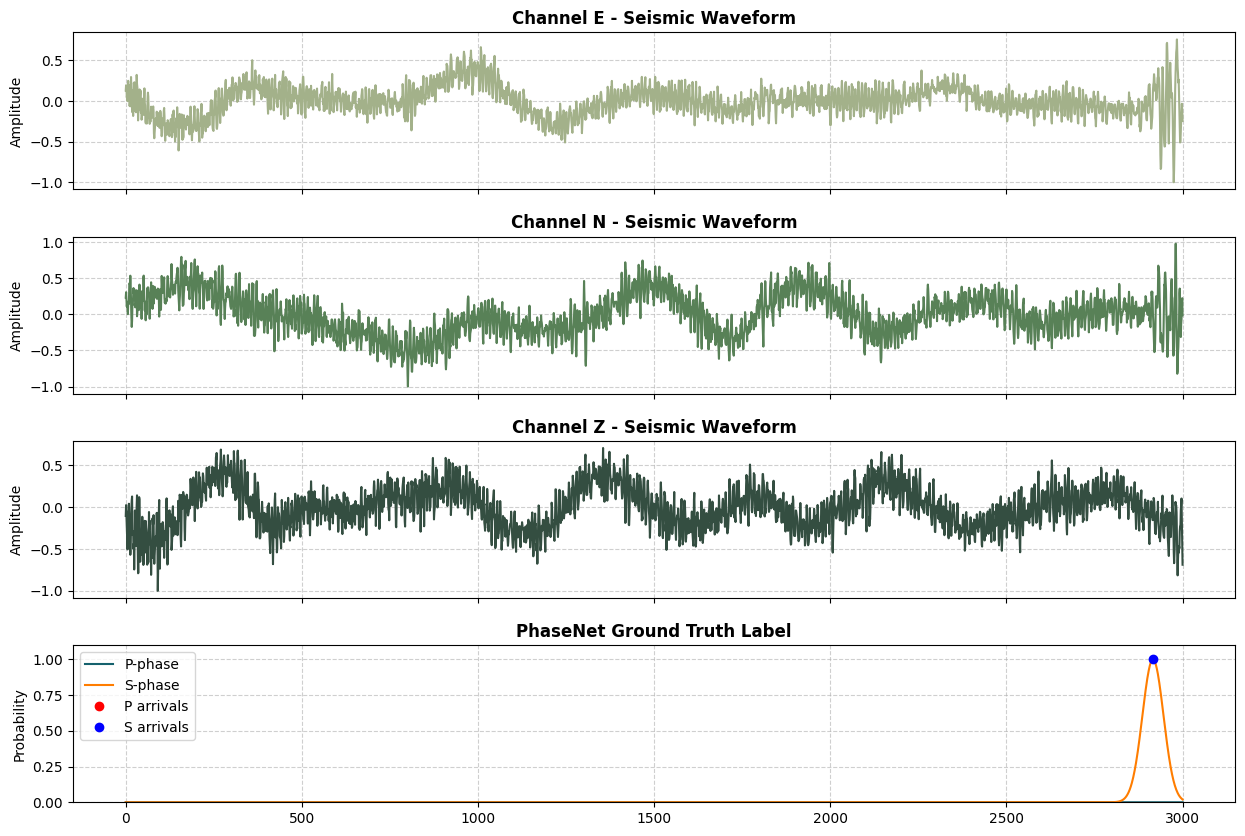

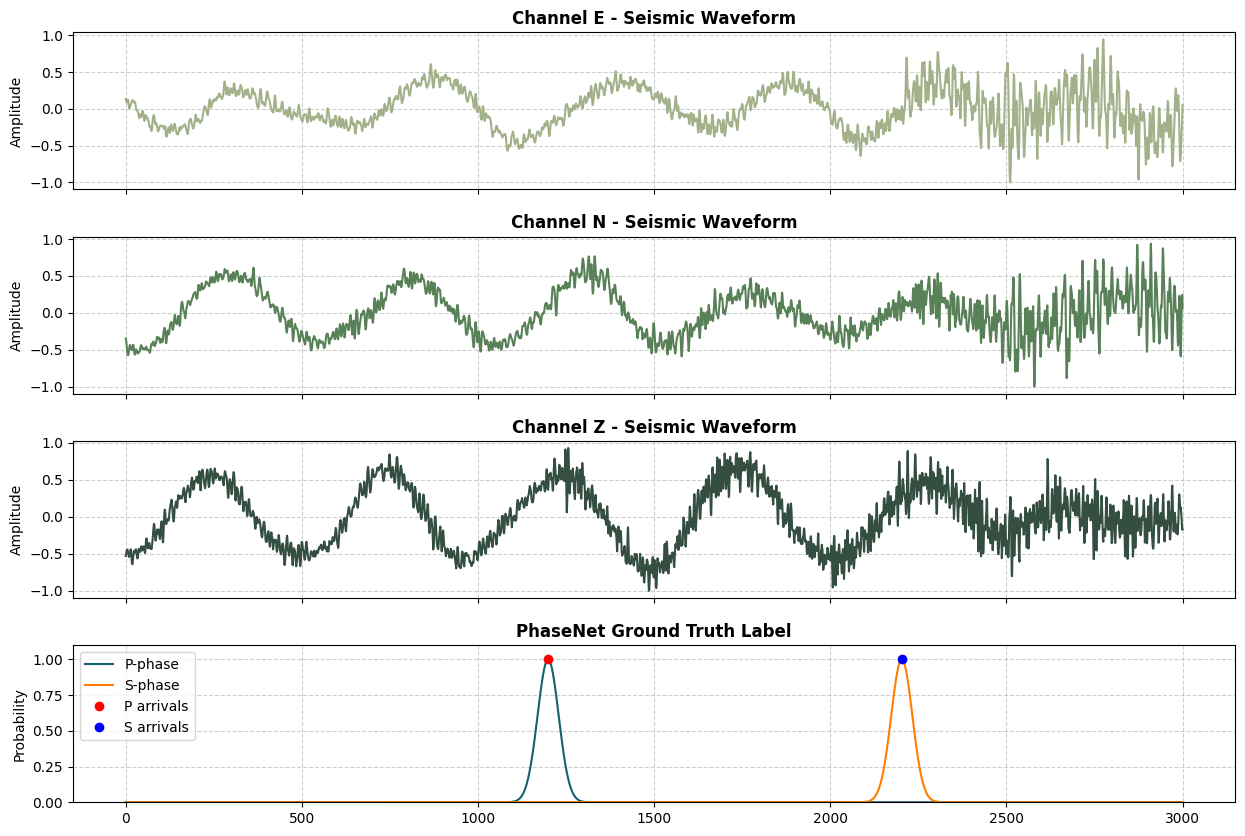

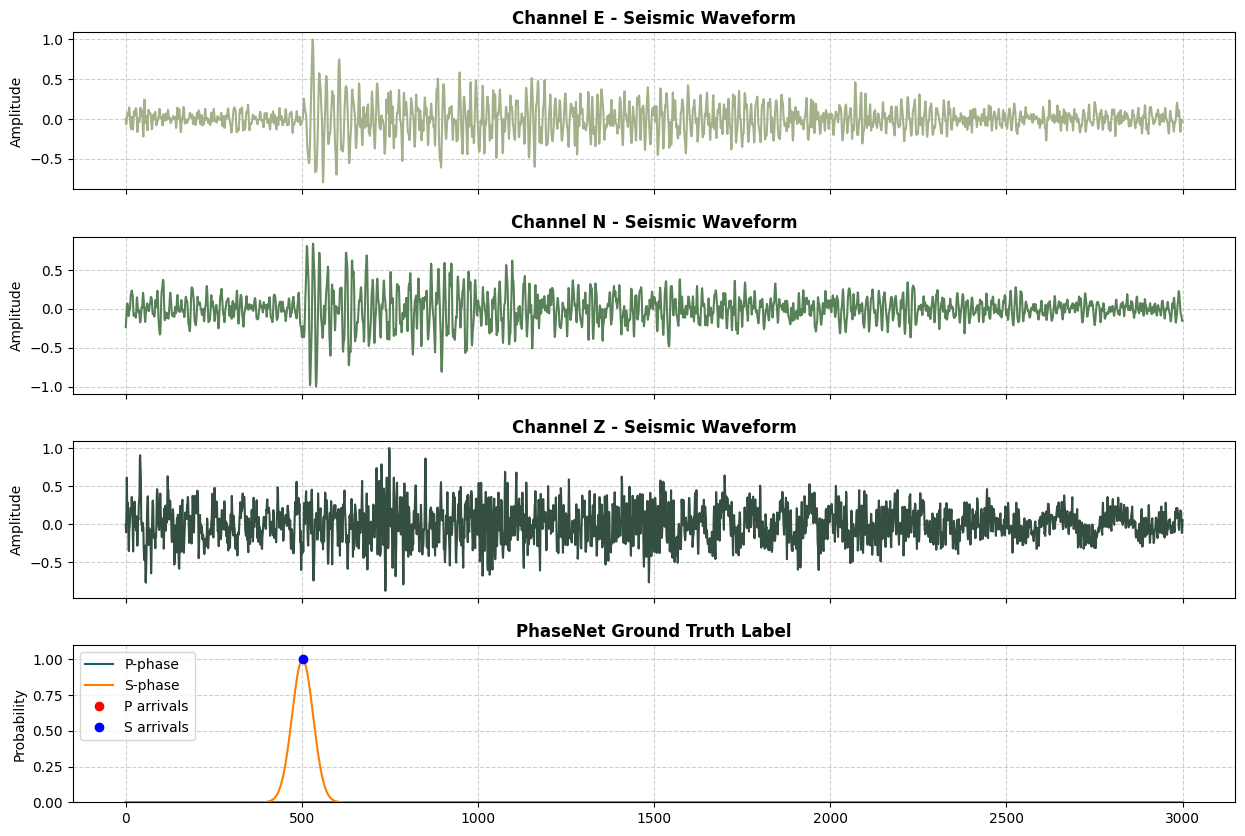

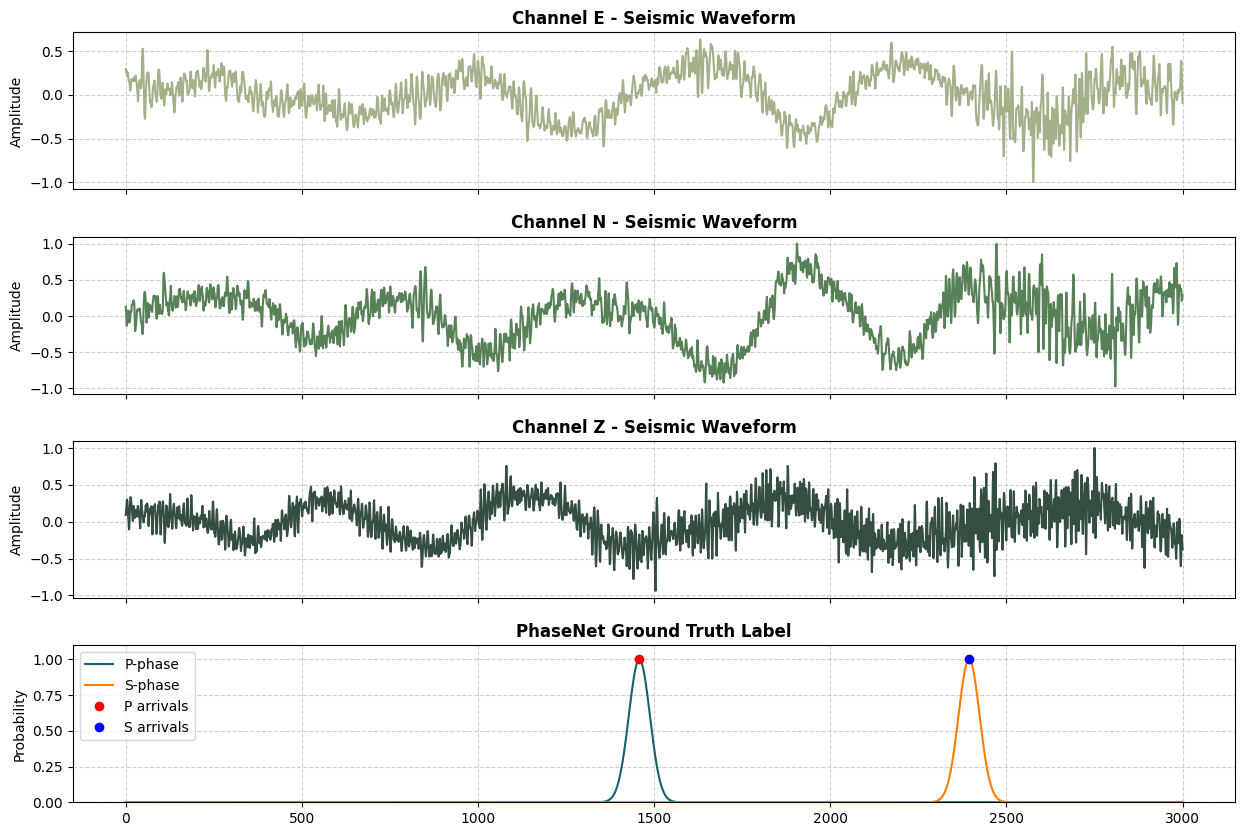

In [21]:
for i in range(1, 5):
    # Visualizing 
    sample = test_generator[np.random.randint(len(test_generator))]

    waveform = sample["X"]  # Shape: (3, N)
    labels = sample["y"]  # Shape: (3, N)

    time_axis = np.arange(waveform.shape[1])  # Create a time axis

    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(4, 1, sharex=True, gridspec_kw={"hspace": 0.3})

    # Color setup
    channel_names = ["Channel E", "Channel N", "Channel Z"]
    waveform_colors = ['#a3b18a', '#588157', '#344e41']  # Custom colors for channels
    label_colors = ['#15616d', '#ff7d00']

    # Plot waveforms
    for j in range(3):
        axs[j].plot(time_axis, waveform[j], color=waveform_colors[j], linewidth=1.5)
        axs[j].set_title(f"{channel_names[j]} - Seismic Waveform", fontsize=12, fontweight='bold')
        axs[j].set_ylabel("Amplitude", fontsize=10)
        axs[j].grid(True, linestyle='--', alpha=0.6)
    
    #axs[0].plot(sample["X"].T)
    #axs[1].plot(sample["y"].T)

    # Find peaks in the ground truth labels
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)

    # Convert ground truth peak indices to time values
    y_p_arrival_times = y_p_peaks / sampling_rate
    y_s_arrival_times = y_s_peaks / sampling_rate

    axs[3].plot(time_axis, labels[0], color=label_colors[0], linewidth=1.5, label="P-phase")
    axs[3].plot(time_axis, labels[1], color=label_colors[1], linewidth=1.5, label="S-phase")
    axs[3].plot(y_p_peaks, sample["y"][0, y_p_peaks], 'o', label='P arrivals', color='red')
    axs[3].plot(y_s_peaks, sample["y"][1, y_s_peaks], 'o', label='S arrivals', color='blue')
    axs[3].set_title("PhaseNet Ground Truth Label", fontsize=12, fontweight='bold')
    axs[3].set_ylim(0,1.1)
    axs[3].set_ylabel("Probability", fontsize=10)
    axs[3].grid(True, linestyle='--', alpha=0.6)
    axs[3].legend(fontsize=10, loc="upper left")
    
    #plot_filename = os.path.join(output_folder, f"Example_{i}_Plot.png")
    #plt.savefig(plot_filename)
    plt.show()

